# CK Mapping

## Model Creation

In [34]:
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
import markdown
import re
from IPython.display import display, Markdown

In [35]:
import pandas as pd

In [36]:
import numpy as np

In [37]:
import re

In [38]:
import matplotlib.pyplot as plt

In [39]:
api_key = "API_KEY"
client = OpenAI(api_key = api_key)

In [40]:
# initial concept input is title and product description
class Concept:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI's refined description
        self.type = "Concept"  # Tracks as a concept

class Knowledge:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI’s deeper reasoning carried forward
        self.type = "Knowledge"  # Tracks as knowledge
        
# 🔹 Graph System for Tracking C-K Transitions 🔹
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.history = []
        self.transition_history = []

    def add_node(self, name, nodetype, description):
        """Generalized method to add either a Concept or Knowledge to the graph."""
        self.graph.add_node(name, type=nodetype, description=description)

    def add_edge(self, parent, child, transformation):
        """Tracks transitions between concepts and knowledge dynamically."""
        self.graph.add_edge(parent.name, child.name, type=transformation)
        self.history.append((parent.name, child.name, transformation))
        self.transition_history.append(transformation)
        print(f"🔄 {transformation}: {parent.name} → {child.name}")

    def visualize_graph(self):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(self.graph)
        labels = nx.get_edge_attributes(self.graph, "type")

        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3500, font_size=10)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()
        

In [41]:
def get_embedding(text, model = "text-embedding-3-small"):
    response = client.embeddings.create(input=text, model=model, dimensions = 512)
    return response.data[0].embedding

In [42]:
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)
    
    return cosine_sim

In [43]:
def extract_knowledge_details(text):
    title_match = re.search(r'Knowledge Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Knowledge Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [44]:
def extract_concept_details(text):
    title_match = re.search(r'Concept Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Concept Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [45]:
def penalize_repetition_check(concept_database, number_concept):
    sys_prompt = f"""
    You are a C-K Theory expert. In the input, I provided {number_concept} sets of consecutive C-->C operations where each group of concepts are separated by a comma and contain a concept title and a concept description. In a C-->C operation the concepts are expanding by partitioning and exploring new attributes. Do these expanding concepts still hold significant ambiguity or unexplored potential that cannot yet be resolved or validated? Note, that this path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on determining whether there exists truly novel propositions that can transform or extend the knowledge space? Are the iterations becoming repetitive in its idea and content? These are questions you ask yourself while determining whether to say Yes or No on whether or not we should continue doing C-->C operation.
    """
    prompt = ', '.join(concept_database)
    response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5
        )
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Respond with a "yes" or "no". Do not include periods in your response.
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [46]:
def givenC_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f"""
    C-K THEORY EXPERT DECISION SYSTEM 
    Your role is to evaluate the current concept/knowledge and determine the optimal transformation.
    The topic you are working on is to {topic}
   
    ---
    Current Concept: {title} 
    Description: {description}
    Past Transformations: {past_transformations}
    Existing Knowledge Base: {past_knowledge}
    Context: 
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step represents the design process.
    Note, the definition of design process in this regard is the process by which a concept generates other concepts or is transformed into knowledge. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.

  🔍 Your Goal:
    1️⃣ Evaluate whether to go from concept to concept or concept to knowledge. Ensure your decision represents the design process based on the information of the current concept, description, past transformations, and existing knowledge base.
    - C-->C (Concept Expansion): Use this if the concept still holds significant ambiguity or unexplored potential that cannot yet be resolved or validated with the existing knowledge base. This path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on exploring whether there exists truly novel propositions that can transform or extend the knowledge space.
    - C-->K (Concept to Knowledge): Choose this path when the concept has been sufficiently refined and aligns with the existing knowledge base, allowing it to be tested, validated, or implemented. This transition is appropriate when the concept can be logically integrated into the knowledge space, resolving its ambiguity and proving its feasibility or truthfulness within the current understanding. Note, the integration of new knowledge is not just about validation but also about whether the concept can enrich the knowledge space. If it meets some of these criteria, it is time to go to K.
Determine whether we should go to concept or knowledge. 
 
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from concept to concept or concept to knowledge. Respond with either 'Concept' for C-->C or 'Knowledge' for C-->K 
    """
    
    response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [47]:
def givenK_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f""""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
 ---
    Current Knowledge: {title}
    Description: {description}
    Past Transformations: {past_transformations}
     Context:
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation.
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.

Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    🔍 Your Goal:
    1️⃣ Evaluate Possible Transformations Dynamically:
    - K→C (Concept Expansion): Used when existing knowledge suggests new concepts or when you suspect new insights from K can lead to the generation of new concepts.
    - K→K (Concept to Knowledge): Used to expand the knowledge space by adding new validated propositions or insights. This is typically performed when new information is created usually from things like C→K.

Use the Current Knowledge Space for reference: [{past_knowledge}]
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from knowledge to concept or knowledge to knowledge. Respond with either 'Concept' for K-->C or 'Knowledge' for K-->K"
    """
    
    response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content
    

In [48]:
def scraped_data_to_string(df_scraped_data):
    """
    This takes in a scraped data from the dataframe and turn it into a string of knowledge bases for LLM inputs
    """
    formatted_strings = []
    for index, row in df_scraped_data.iterrows():
        # format the string for each row
        formatted_string = f"Title: {row['Title']} Description: {row['Description']}"
        # append the formatted string to the list
        formatted_strings.append(formatted_string)

    result = ''.join(formatted_strings)
    return result

In [49]:
def determine_operation_concept2(concept_title, concept_description, df_knowledge, transition_history, topic, force_k, concept_space):
    past_concepts = ', '.join(transition_history)
    past_transitions = ', '.join(transition_history)
    past_knowledge = scraped_data_to_string(df_knowledge)
    determine_operation_direc = givenC_determine_c_or_k(concept_title, concept_description, past_transitions, past_knowledge, topic)
    if force_k is True:
        transition_choice = 'C-->K' 
        prompt_c_to_k = f"""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI Specializing in Design Innovation using C-K  Theory.
Your role is to evaluate the current concept.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
Existing Concept Space *this is just for reference as to what has already been done* (each concepts are separated by a comma): {past_concepts}
Existing Knowledge Space: {past_knowledge}
Description: {concept_description}
Past Transitions: {past_transitions}
Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
            """

        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
    else: 
        if determine_operation_direc.lower() == "concept":
            transition_choice = 'C-->C'
            prompt_c_to_c = f"""
        C-K THEORY EXPERT DECISION SYSTEM
        You are an AI Specializing in Design Innovation using C-K  Theory.
        Your role is to evaluate the current concept.
        The topic you are working on is to {topic}
        You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
        Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
        Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
        Existing Concept Space *this is just for reference as to what has already been done, so do not copy the concepts* (each concepts are separated by a comma): {past_concepts}
        Existing Knowledge Space: {past_knowledge}
        Current Concept: {concept_title} 
        Description: {concept_description}  
        Past Transitions: {past_transitions}
        Your goal is to identify specific areas of the concept that remains unexplored or ambiguous. Utilize the existing knowledge base as a reference to guide your exploration. The goal is to get truly novel propositions and attributes that can enhance the concept space and lead to new discovery in the knowledge space.
        Provide a new concept title and description.
          """


            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content

        elif determine_operation_direc.lower() == "knowledge":
            transition_choice = 'C-->K' 
            prompt_c_to_k = f"""
        C-K THEORY EXPERT DECISION SYSTEM
    You are an AI Specializing in Design Innovation using C-K  Theory.
    Your role is to evaluate the current concept.
    The topic you are working on is to {topic}
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    Existing Concept Space *this is just for reference as to what has already been done* (each concepts are separated by a comma): {past_concepts}
    Existing Knowledge Space: {past_knowledge}
    Current Concept: {concept_title}
    Description: {concept_description}
    Past Transitions: {past_transitions}
    Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
                """

            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
            new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
            df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
            # compute embeddings only for new row
#             new_index = df_knowledge.index[-1]
#             df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#             df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)

        else:
            error_message = f"Error: The operation direction '{determine_operation_direc}' is not recognized. It must be either 'concept' or 'knowledge'."
            raise ValueError(error_message)
    return final_title, final_desc, transition_choice, df_knowledge

In [50]:
def determine_operation_knowledge(knowledge_title, knowledge_description, df_knowledge, transition_history, topic, concept_space):
    """Input: concept_title (text), concept_description (text), dataframe knowledge space (pandas df), past_transitions
    Output: chosen operation and new concept/knowledge title + description"""
    past_concepts = ', '.join(concept_space)
    past_transitions = ', '.join(transition_history)
    transition_choice = None
    past_knowledge = scraped_data_to_string(df_knowledge)
    K_or_C = givenK_determine_c_or_k(knowledge_title, knowledge_description, past_transitions, past_knowledge, topic)
    
    if K_or_C.lower() == "knowledge":
        transition_choice = "K-->K"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
 Existing Concept Space *this is just for reference* (each concepts are separated by a comma): {past_concepts}
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to expand the knowledge space by adding new validated propositions or insights. Utilize the concept space for reference.
 And use the current Knowledge Space for reference: [{past_knowledge}]
        """
        
        response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        
        response_title = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
        
    elif K_or_C.lower() == "concept":
        transition_choice = "K-->C"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
 Existing Concept Space *this is just for reference* (each concepts are separated by a comma): {past_concepts}
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to to use existing knowledge to suggest new concepts. Avoid repeating concepts in the concept space. Instead, add new propositions and novelty to the concept space.
 Use the current Knowledge Space for reference: [{past_knowledge}]
        """
        
        response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        
        response_title = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        
    else: 
        error_message = f"Error: The operation direction '{K_or_C}' is not recognized. It must be either 'concept' or 'knowledge'."
        raise ValueError(error_message)
        
    
    return final_title, final_desc, transition_choice, df_knowledge
 

In [51]:
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_node(self, name, type, description):
        self.graph.add_node(name, type=type, description=description)

    def add_edge(self, parent_name, child_name, transition_choice):
        self.graph.add_edge(parent_name, child_name, transition=transition_choice)


In [52]:
system = ConceptKnowledgeSystem()

In [53]:
df_know_embed = pd.read_csv('data/amazon links/hammering_nail_req.csv')

In [54]:
current_type = "concept"
current_desc = "A nail holder avoiding to hurt one's hand while hammering"
current_title = "Avanti nail holder"
past_transitions = []
# df_know_embed = pd.read_pickle('data/amazon links/amazon_nail_embedding.pkl')
topic = "design a creative nail holder for when a person is hammering a nail."
list_concepts = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
concept_space = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
num_C_repeat = 0
force_k = False
similarity_lists = []
avg_iteration_sim = []

In [55]:
for i in range(50):
    if current_type == "concept":
        # Determine the next operation from the concept
        new_title, new_desc, transition_choice, new_df = determine_operation_concept2(current_title, current_desc, df_know_embed, past_transitions, topic, force_k, concept_space)
        
    elif current_type == "knowledge": 
        new_title, new_desc, transition_choice, new_df = determine_operation_knowledge(current_title, current_desc, df_know_embed, past_transitions, topic, concept_space)
    
    else:
        print("there was an issue in identifying current type")
        pass
    
    system.add_node(current_title, current_type, current_desc)
    if transition_choice in ["C-->C", "K-->C"]:
        new_type = "concept"
    elif transition_choice in ["C-->K", "K-->K"]:
        new_type = "knowledge"
    else:
        print("there was an issue in getting the new type")
        pass
    print(f"Iteration {i+1}:")
    print(f"  Current Title: {current_title}")
    print(f"  Current Description: {current_desc}")
    print(f"  Transition: {transition_choice}")
    print(f"  New Title: {new_title}")
    print(f"  New Description: {new_desc}")
    print(f"  Past Transitions: {past_transitions}")
    print("-" * 40)
    
    system.add_edge(current_title, new_title, transition_choice)
    past_transitions.append(transition_choice)
    concept_space.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
    embedded_concept_space = [get_embedding(concept) for concept in concept_space]
    
    if len(embedded_concept_space) < 2:
        pass
    else:
        avg_sims = []
        iteration_similarities = []
        count = 0
        total_similarity = 0
        for i in range(len(embedded_concept_space)):
            for j in range(i+1, len(embedded_concept_space)):
                similarity = cosine_similarity(embedded_concept_space[i], embedded_concept_space[j])
                iteration_similarities.append(similarity)
            if iteration_similarities:
                # note this is the average similarity for all individual i iterations
                average_sim = sum(iteration_similarities)/len(iteration_similarities)
                avg_sims.append(average_sim)
        similarity_lists.append(iteration_similarities)
        avg_iteration_sim.append(avg_sims)
    
#     if transition_choice in ["C-->C"]:
#         list_concepts.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
#         num_C_repeat += 1
#         if num_C_repeat >= 5:
#             decision_on_k = penalize_repetition_check(list_concepts, num_C_repeat)
#             if decision_on_k.lower() == 'yes':
#                 force_k = True
#                 print("This is the decision from the repetition checker", decision_on_k)
#             else:
#                 print("This is the decision from the repetition checker", decision_on_k)
#                 force_k = False
#     else:
#         list_concepts = []
#         num_C_repeat = 0
#         force_k = False
    
    df_know_embed = new_df
    current_title, current_desc, current_type = new_title, new_desc, new_type
    

Iteration 1:
  Current Title: Avanti nail holder
  Current Description: A nail holder avoiding to hurt one's hand while hammering
  Transition: C-->C
  New Title: [Magnetic Suspension Nail Holder: Injury-Free Precision Through Adjustable Magnetic Alignment and Ergonomic Release]
  New Description: [The Magnetic Suspension Nail Holder is a novel nail positioning device designed to eliminate the risk of finger injury by utilizing a finely-tuned magnetic suspension system. This innovative approach securely holds nails of varying sizes and materials without direct human contact, ensuring precise alignment and clear visibility of the nail head and target area. The device features an ergonomic activation grip allowing users to effortlessly position and release nails with one-handed operation, enhancing ease of use, accuracy, and safety. Constructed from lightweight, durable, and corrosion-resistant materials, the Magnetic Suspension Nail Holder provides reliable performance, portability, and

Iteration 5:
  Current Title: [Strategic Expansion of Concept Space: Multi-Mode Adaptive Grip, Cost-Optimized Magnetic-Mechanical Integration, Smart Feedback Systems, Telescopic Ergonomics, and Wearable Hands-Free Solutions for Universal, Safe, and User-Accepted Nail Holder Innovation]
  Current Description: [Concept Title: Multi-Mode Adaptive Grip Nail Holder  
Concept Description: A nail holder integrating adaptive mechanical gripping jaws, magnetically-assisted guidance, and adjustable friction-enhanced clamps into a unified assembly. It automatically senses nail materials and adjusts gripping force accordingly, ensuring secure retention of both ferromagnetic and non-ferromagnetic nails. This adaptive mechanism maximizes user safety, ergonomic comfort, ease of use, and precise alignment without extensive manual adjustments.

Concept Title: Cost-Optimized Magnetic-Mechanical Nail Holder  
Concept Description: A nail holder strategically combining cost-effective composite or hybrid ma

Iteration 8:
  Current Title: [Collaborative AI-Enhanced Multi-User Nail Holder System Integrating Real-Time Team Coordination Analytics and Cooperative Skill Development]
  Current Description: [Concept Title: Collaborative AI-Assisted Multi-User Nail Holder System for Team Coordination and Workshop Learning Environments

Concept Description: An advanced nail holder system specifically designed to support collaborative teamwork and shared learning scenarios in workshops, training centers, and educational settings. This innovative concept integrates multiple intelligent nail holders wirelessly through a smart network platform, enabling real-time collection and analysis of team-level performance data, including synchronization, hammering accuracy, nail placement consistency, skill variations, and adherence to safety protocols.

Leveraging artificial intelligence and advanced analytics, the system provides coordinated, real-time feedback to individual users within a collaborative context

Iteration 11:
  Current Title: [Integrated Biofeedback and Emotion-Adaptive Nail Holder: Real-Time Stress Detection and Adaptive Tactile Guidance for Enhanced Precision, Confidence, and User Well-being]
  Current Description: [Concept Title: Integrated Biofeedback and Emotion-Adaptive Nail Holder for Enhanced User Confidence and Stress Mitigation during Hammering Tasks

Concept Description: An innovative nail holder system integrating real-time biometric sensing and adaptive emotional feedback mechanisms to enhance user confidence, reduce stress, and improve precision during hammering tasks. Embedded biometric sensors—including galvanic skin response (GSR), heart rate variability (HRV), and muscle tension detectors—continuously monitor the user's physiological and emotional states, identifying stress, anxiety, hesitation, or discomfort. Leveraging this biofeedback data, the nail holder dynamically adjusts the intensity, frequency, and modality of tactile haptic feedback and physical gu

Iteration 14:
  Current Title: [AI-Enhanced Adaptive Nail Holder Integrating Real-Time Cognitive Load Management, Embodied Skill Transfer, and Dynamic Multimodal Feedback for Individual and Collaborative Precision Mastery]
  Current Description: [Concept Title: AI-Enhanced Adaptive Nail Holder with Embodied Skill Transfer and Dynamic Cognitive Load Management

Concept Description: An innovative nail holder system integrating artificial intelligence (AI) and advanced multimodal sensing technologies to dynamically manage cognitive load and embodied skill acquisition during individual and collaborative hammering tasks. The device continuously monitors precision metrics, psychophysiological indicators (attention, stress, muscle activation), hand positioning, and hammer striking dynamics. Utilizing real-time data analysis, the embedded AI engine identifies optimal skill-building opportunities and strategically delivers personalized interventions—including adaptive tactile haptic feedback, s

Iteration 17:
  Current Title: [Neuro-Integrated Collective Intelligence Nail Holder with Real-Time Collaborative Ergonomic Optimization, Socially-Aware Adaptive Feedback, and Multi-User Cognitive Synchronization for Enhanced Precision, Safety, and Team Efficiency]
  Current Description: [Concept Title: Neuro-Integrated Collective Intelligence Nail Holder with Real-Time Collaborative Task Optimization and Socially-Aware Adaptive Ergonomics

Concept Description: An advanced nail holder system that integrates neuro-sensing technologies and collective intelligence analytics to optimize collaborative hammering tasks in real-time. By continuously monitoring cognitive and physiological signals (such as EEG-based attention, stress levels, muscular fatigue, and motor coordination) from multiple users simultaneously, the system identifies subtle interpersonal dynamics, communication inefficiencies, and emerging safety risks within team-based construction scenarios. Leveraging machine learning a

Iteration 20:
  Current Title: [Modular Smart Robotic Nail Holder Ecosystem with Multi-Tool Integration, Adaptive Material Recognition, and Context-Aware Expert Assistance for Enhanced Precision, Safety, and Versatility]
  Current Description: [Concept Title: Modular Smart Robotic Nail Holder Ecosystem with Configurable Tool Integrations, Adaptive Material Recognition, and Context-Aware Expert Assistance

Concept Description: A modular robotic nail holder ecosystem composed of standardized, interchangeable robotic modules capable of dynamically integrating multiple carpentry tools—including drills, screwdrivers, and leveling instruments—in addition to nail-holding functionality. Equipped with advanced adaptive material recognition sensors (acoustic resonance, ultrasonic sensing, electromagnetic scanning), the system autonomously identifies substrate materials such as wood, drywall, concrete, composite surfaces, and metals. Based on real-time material detection, the robotic modules auto

Iteration 22:
  Current Title: [Neuro-Adaptive Biosensing Nail Holder Integrating Emotional-Affective Feedback and Cognitive Ergonomics for Enhanced User Comfort and Safety in Carpentry Tasks]
  Current Description: [Concept Title: Neuro-Adaptive Collaborative Nail Holder with Integrated Emotional-Affective Biosensing Feedback for Enhanced Ergonomic and Psychological Comfort in Carpentry Tasks

Concept Description: A novel nail holder system integrating advanced neuro-adaptive biosensing technologies within a bio-inspired adaptive gripping mechanism. Miniature biosensors embedded strategically within ergonomic grip points detect physiological markers such as skin conductance, pulse rate, and muscle tension, continuously monitoring the user's emotional-affective state, cognitive workload, stress, and fatigue levels during hammering tasks.

Leveraging sophisticated machine-learning algorithms and cognitive-affective classification models, the nail holder dynamically interprets biometric 

Iteration 24:
  Current Title: [Collaborative Multi-User Biofeedback Nail Holder System with Coordinated Adaptive Smart-Material Ergonomics for Proactive Team Safety and Social-Affective Optimization in Carpentry Tasks]
  Current Description: [Concept Title: Collaborative Multi-User Biofeedback Nail Holder System with Coordinated Team Safety Optimization

Concept Description: A novel nail holder system designed explicitly for collaborative carpentry and construction tasks, integrating synchronized multi-user biofeedback and predictive analytics to proactively optimize team safety, comfort, and precision. Distributed biosensors embedded within each user's nail holder continuously monitor individual physiological indicators such as stress, fatigue, muscle strain, and cognitive workload. Advanced AI-driven algorithms analyze collective psychophysiological data in real-time, dynamically adapting each user's nail holder ergonomics—including grip shape, stiffness, shock absorption, and tacti

Iteration 26:
  Current Title: [Integrative Emotional-AI Trust Calibration Interface with Immersive AR Transparency for Adaptive Autonomous Nail-Positioning and Cooperative Haptic Guidance Systems]
  Current Description: [Concept Title: Integrative Emotional-AI Interface with Adaptive User-Trust Calibration for Autonomous Nail Positioning and Haptic Cooperative Systems

Concept Description: An advanced nail holder innovation designed to strategically address unexplored dimensions of user trust, emotional acceptance, and cognitive transparency in autonomous nail-positioning and collaborative haptic guidance systems. This concept introduces an integrative Emotional Artificial Intelligence (Emotional-AI) framework that dynamically calibrates user trust and emotional comfort levels, continuously adapting the autonomy and intervention intensity of the nail-positioning system based on real-time affective sensing and user feedback.

The system employs affective sensing technologies to proacti

Iteration 28:
  Current Title: [Emotionally Intelligent Adaptive Nail Holder System Integrating Real-Time User Emotional State Recognition and Personalized Multimodal Feedback for Enhanced Confidence, Skill Development, and Safety]
  Current Description: [Concept Title: Emotionally Intelligent Nail Holder with Adaptive User-Awareness Feedback System for Enhanced Confidence and Skill Development

Concept Description: An innovative nail holder concept integrating emotional intelligence and adaptive user-awareness capabilities to enhance user confidence, reduce anxiety, and facilitate skill development during hammering tasks. Utilizing physiological sensors—including heart rate variability, galvanic skin response, facial expression analysis, and gesture recognition—the system dynamically assesses the user's emotional and cognitive states in real-time. Advanced machine learning algorithms interpret these emotional indicators, identifying user anxiety, frustration, fatigue, hesitation, or c

Iteration 30:
  Current Title: [Self-Learning Collaborative Nail Holder System Integrating Predictive User Skill Modeling, Iterative Task Optimization, and Adaptive Autonomy for Enhanced Precision, Safety, and Long-Term Skill Development]
  Current Description: [Concept Title: Self-Learning Collaborative Nail Holder System: Integrating Dynamic Predictive Analytics, Iterative Task Optimization, and User-Specific Skill Evolution Modeling

Concept Description: This innovative nail holder system expands upon previous emotionally intelligent robotic interaction frameworks by incorporating advanced self-learning artificial intelligence capabilities. The system dynamically improves its performance through iterative cycles of predictive analytics, real-time user feedback, and cumulative interaction history. By continuously capturing and analyzing user-specific hammering styles, skill progression patterns, biometric emotional data, and environmental context, the collaborative robotic component 

Iteration 32:
  Current Title: [Collaborative Learning Nail Holder System Integrating Community-Sourced Biofeedback Analytics for Personalized Ergonomic Skill Optimization and Collective Precision Enhancement]
  Current Description: [Concept Title: Collaborative Learning Nail Holder System Leveraging Social and Community-Generated Biofeedback Analytics for Personalized Ergonomic Skill Optimization and Collective Precision Improvement

Concept Description: This concept expands upon existing emotionally adaptive biofeedback nail holder systems by integrating collective community learning and collaborative analytics. The nail holder captures biometric, ergonomic, physiological, and behavioral data anonymously from a broad user community, aggregating these insights to identify optimal ergonomic practices, emotional regulation strategies, and precision-enhancing techniques. Advanced adaptive algorithms dynamically incorporate these community-generated insights into personalized, real-time m

Iteration 34:
  Current Title: [Emotionally Adaptive Predictive-Robotic Nail Holder Leveraging Affective Analytics and Real-Time Biofeedback for Enhanced Safety, Precision, and Psychological Ergonomics]
  Current Description: [Concept Title: Emotionally Adaptive Predictive-Robotic Nail Holder Enhanced by Affective Analytics and Real-Time Biofeedback Integration

Concept Description: This concept introduces an advanced predictive-robotic nail holder system explicitly augmented with affective analytics and real-time biofeedback sensing capabilities. Recognizing that emotional states such as stress, anxiety, frustration, or fatigue significantly influence user safety, precision, and ergonomic performance during hammering tasks, the system integrates validated affective models derived from aggregated community-generated emotional and biometric data (e.g., galvanic skin response, heart rate variability, neurophysiological indicators).

The embedded robotic subsystem dynamically adapts its i

Iteration 36:
  Current Title: [Emotionally Collaborative AI Nail Holder Integrating Context-Aware Environmental Intelligence, Dynamic Task Optimization, Multi-Dimensional Adaptive Interaction, Transparent Scenario Communication, and Lifecycle Sustainability]
  Current Description: [Concept Title: Emotionally Collaborative AI Nail Holder with Context-Aware Environmental Intelligence and Integrated Dynamic Task Optimization

Concept Description: This concept strategically expands upon the existing Collaborative AI Nail Holder by integrating context-aware environmental intelligence and dynamic task optimization capabilities. The advanced nail holder system continuously senses and interprets external environmental conditions—including lighting, ambient noise, humidity, temperature, workspace geometry, and target surface materials—and dynamically integrates this environmental data with personalized emotional, ergonomic, and skill-adaptive user profiles. By synthesizing multi-dimensional in

Iteration 38:
  Current Title: [Self-Learning Robotic Nail Holder with Predictive Kinesthetic Modeling, Adaptive Cognitive Trust Calibration, Blockchain-Based Ergonomic Transparency, Dynamic Force-Damping Safety, and Energy-Harvesting Sustainability Integration]
  Current Description: [Concept Title: Self-Learning Robotic Augmented Nail Holder Integrating Predictive Kinesthetic Modeling, Adaptive Cognitive Trust Calibration, and Blockchain-Based Ergonomic Optimization

Concept Description: This concept strategically expands upon the Adaptive Biofeedback Nail Holder by introducing a robotic augmentation framework with advanced self-learning capabilities. The nail holder continuously captures and analyzes user-specific kinesthetic movement patterns, grip adjustments, and anticipatory muscle activations through predictive machine-learning algorithms. By proactively modeling these subtle user movements, the robotic system dynamically positions nails and guides hammering trajectories, signi

Iteration 40:
  Current Title: [Self-Learning Emotional Biofeedback Nail Holder Integrating AI-Driven Adaptive Ergonomics, Context-Aware Environmental Responsiveness, Autonomous Trust Calibration, and Personalized CSR Lifecycle Optimization]
  Current Description: [Concept Title: Self-learning Emotional Biofeedback Nail Holder with AI-Powered Adaptive Ergonomics, Context-Aware Environmental Responsiveness, and User-Personalized Performance Evolution

Concept Description: This concept strategically expands the existing emotionally-responsive AR nail holder innovation by introducing continuous AI-driven self-learning capabilities. It proposes embedding generative artificial intelligence algorithms within the nail holder system, enabling it to autonomously evolve and personalize its emotional responsiveness, ergonomic adaptation, and environmental awareness based on cumulative user interactions and biofeedback data. Specifically, the concept explores five novel and previously unexplored d

Iteration 42:
  Current Title: [Symbiotic Bio-Sensing Smart Nail Holder with Real-Time Biological Feedback, Individualized Ergonomic Memory, Microbial Sustainability, Collective Intelligence Networks, and Bio-Inspired Structural Integrity Monitoring]
  Current Description: [Concept Title: Symbiotic Bio-Sensing and Adaptive Learning Smart Nail Holder integrating Real-Time Biological Feedback, Individualized Ergonomic Memory, Microbial-Enhanced Sustainability, and Collective Intelligence Networks

Concept Description: This concept strategically expands the Bio-Inspired Self-Regenerative Smart Nail Holder by systematically exploring previously ambiguous and unexplored dimensions, specifically:

(1) Real-Time Biofeedback Integration for Enhanced Ergonomics: Incorporating advanced bio-sensing technologies (pressure-sensitive grips, sweat-based temperature sensors, bio-electrical impedance analysis) to continuously monitor user physiological data during nail hammering tasks. This real-time b

Iteration 44:
  Current Title: [Integrated Self-Calibrating Neuro-Adaptive Nail Holder with Environmental Context Awareness, AR-Guided Skill Mastery, Bio-Inspired Self-Healing Materials, and Ethical UX Transparency]
  Current Description: [Concept Title: Integrated Self-Calibrating Neuro-Functional Nail Holder with Environmental Context Awareness, Multi-Sensory AR Guidance, Bio-Informed Self-Healing Materials, and Ethical UX Transparency

Concept Description: This concept strategically explores previously ambiguous and unexplored dimensions within the nail holder design space, specifically:

(1) Self-Calibrating Neuro-Functional Personalization: Incorporating advanced neuro-feedback sensors that continuously monitor user neuromotor signals, including muscle coordination, fine motor precision, and subtle tremors. The nail holder dynamically calibrates its alignment, grip angle, ergonomic shape, and positioning in real-time, progressively adapting to individual neuromuscular profiles. Th

Iteration 46:
  Current Title: [Multi-Sensory Haptic Feedback Nail Holder with Dynamic Shape-Memory Ergonomics, Closed-Loop Eco-Lifecycle Awareness, and AI-Gamified Skill Coaching]
  Current Description: [Concept Title: Multi-Sensory Feedback and Self-Calibrating Haptic Adaptive Nail Holder with Dynamic Shape-Memory Structural Transformation and Closed-loop Eco-Feedback System

Concept Description: This concept strategically explores previously ambiguous and unexplored dimensions within the nail holder design space, specifically:

(1) Multi-Sensory and Real-Time Haptic Feedback Recalibration: Integrating advanced physiological sensing technologies, the nail holder provides real-time multi-sensory feedback through subtle vibratory and auditory signals. These signals dynamically respond to user physiological states (stress, heart rate, perspiration) and hammering precision, intuitively guiding users toward improved accuracy, ergonomic posture, and reduced fatigue during prolonged or chal

Iteration 48:
  Current Title: [Adaptive Bio-Integrated Energy-Harvesting Nail Holder with Ethical AI Transparency, Multi-Generational Sustainable Lifecycle, and Predictive Neuromodulation Safety Integration]
  Current Description: [Concept Title: Adaptive Nail Holder with Bio-Integrated Energy Harvesting, Ethical AI Transparency, Sustainable Lifecycle Management, and Predictive Neuromodulation Safety Integration

Concept Description: This concept strategically expands the nail holder design space by explicitly addressing previously unexplored dimensions:

(1) Bio-Integrated Energy Harvesting for Autonomous Operation:  
Embedding bio-inspired energy harvesting technologies—such as piezoelectric generators activated by finger movements or hammer impacts, thermoelectric micro-harvesters utilizing skin temperature gradients, or microbial bio-fuel cells powered by sweat chemistry—enables the nail holder to achieve continuous, independent energy autonomy. This innovation significantly enhan

Iteration 50:
  Current Title: [Collaborative Multi-User Adaptive Nail Holder with Socially-Aware Safety Intelligence, Real-Time Contextual Feedback, and Energy-Autonomous Sustainability Integration]
  Current Description: [Concept Title: Adaptive Socially-Aware Collaborative Nail Holder System with Multi-User Contextual Optimization and Real-Time Feedback Loop Integration

Concept Description: This concept strategically expands the nail holder design space by explicitly addressing previously unexplored dimensions:

(1) Collaborative Multi-User Contextual Intelligence:  
The nail holder integrates distributed sensing networks and spatial positioning technologies, enabling dynamic synchronization of ergonomic and task optimization adjustments across multiple interconnected holders and users. This multi-user adaptability facilitates seamless role transitions, optimized workflow management, and enhanced team coordination during complex hammering tasks.

(2) Socially-Aware Safety Enhanceme

In [56]:
averages = [sum(sublist)/len(sublist) for sublist in avg_iteration_sim]

In [57]:
averages2 = [sum(sublist)/len(sublist) for sublist in similarity_lists]

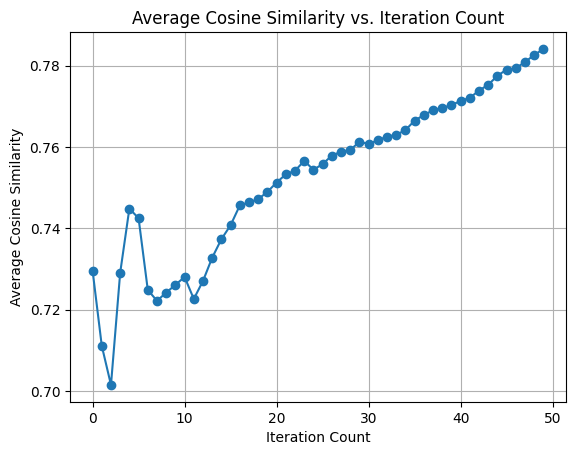

In [58]:
plt.plot(range(len(averages)), averages, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

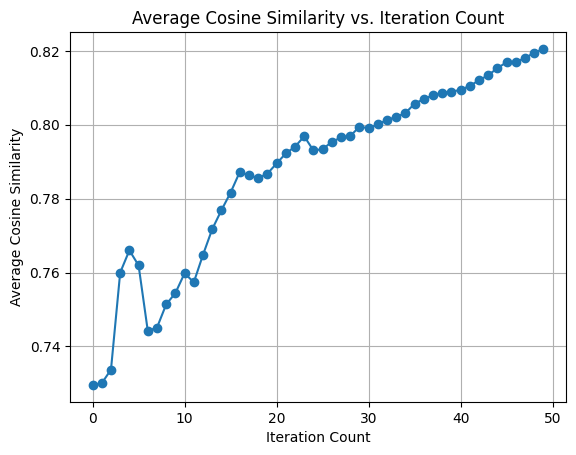

In [59]:
plt.plot(range(len(averages2)), averages2, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

## Saving embeddings

In [60]:
import pickle

In [61]:
df_know_embed.to_csv("know-space_withoutFBloop_ConMemYes-gp4.5.csv")

In [62]:
df_con = pd.DataFrame(concept_space, columns = ['concepts'])

In [63]:
df_con.to_csv("con-space_withoutFBloop_ConMemYes-gpt4.5.csv")

In [64]:
with open('avg_iter_sim_withoutFBloop_ConMemYes-gpt4.5.pkl', 'wb') as file:
    pickle.dump(avg_iteration_sim, file)

In [65]:
with open('sim_list_withoutFBloop_ConMemYes-gpt4.5.pkl', 'wb') as file:
    pickle.dump(similarity_lists, file)

In [66]:
with open('past_transitions_withoutFBloop_ConMemYes-gpt4.5.pkl', 'wb') as file:
    pickle.dump(past_transitions, file)

## Calculating Diversity

In [70]:
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

In [54]:
embdding_c_space = [get_embedding(concept) for concept in concept_space]

In [71]:
def convexhull(x, n_components):
    pca = PCA(n_components = n_components)
    reduced_data = pca.fit_transform(x)
    explained_ratio = pca.explained_variance_ratio_
    hull = ConvexHull(reduced_data)
    volume = hull.volume
    return volume, explained_ratio

In [72]:
def DPP_diversity(x, lambda0=0):
    # Normalize the rows of x to have unit norm
    x_normalized = x / np.linalg.norm(x, axis=1, keepdims=True)
    
    # Compute the cosine similarity matrix S
    S = np.dot(x_normalized, x_normalized.T)
    
    # Transform cosine similarity values to be non-negative
    S_non_negative = (S + 1.0) / 2.0
    
    # Create a vector of ones with the same length as the number of points in x
    y = np.ones(x.shape[0])
    
    # Compute the outer product of y with itself
    Q = np.outer(y, y)
    
    if lambda0 == 0:
        L = S_non_negative
    else:
        L = S * np.power(Q, lambda0)
    
    try:
        eig_val = np.linalg.eigh(L)[0]
    except np.linalg.LinAlgError:
        eig_val = np.ones_like(y)
    
    loss = np.mean(np.log(np.maximum(eig_val, 1e-7)))
    return loss

In [73]:
def L2_vectorized(X, Y):
    #Vectorize L2 calculation using x^2+y^2-2xy
    X_sq = np.sum(np.square(X), axis=1)
    Y_sq = np.sum(np.square(Y), axis=1)
    sq = np.add(np.expand_dims(X_sq, axis=-1), np.transpose(Y_sq)) - 2*np.matmul(X,np.transpose(Y))
    sq = np.clip(sq, 0.0, 1e12)
    return np.sqrt(sq)

In [74]:
def distance_to_centroid(embeddings):
    distances = []
    for i in range(embeddings.shape[0]):
        pca = PCA(n_components = 20)
        embeddings = pca.fit_transform(embeddings)
        mean = np.mean(embeddings[i])
        dist = np.sqrt(np.sum(np.square(np.subtract(embeddings[i], mean))))
        distances.append(dist)
    return np.mean(np.array(distances))

In [75]:
def calc_distance(X, Y, distance="Euclidean"):
    if distance=="Euclidean":
        return L2_vectorized(X,Y)
    else:
        raise Exception("Unknown distance metric specified")

In [76]:
def gen_gen_distance(embeddings, reduction):
    x = embeddings
    res = calc_distance(x, x, distance="Euclidean")
    
    # This sets the diagonal of the matrix to the maximum of elements across the column dimension
    np.fill_diagonal(res, np.max(res, axis=1))
    
    # Pick the smallest values along the columns
    if reduction == "min":
        scores = np.min(res, axis=1)
    # Pick the average value along the columns
    elif reduction == "ave":
        scores = np.mean(res, axis=1)
    else:
        raise Exception("Unknown reduction method")
    
    return np.mean(scores)

In [77]:
convexhull(embdding_c_space, n_components = 15)

(7.358644468108615e-16,
 array([0.21070075, 0.10325271, 0.05930602, 0.04992644, 0.04669875,
        0.03957802, 0.03313273, 0.03177289, 0.029053  , 0.02650959,
        0.02431804, 0.023713  , 0.02176334, 0.01914987, 0.0173171 ]))

## Visualize Graph

In [ ]:
def visualize_graph(system):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(system.graph)
        labels = nx.get_edge_attributes(system.graph, "transition")

        nx.draw(system.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
        nx.draw_networkx_edge_labels(system.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()